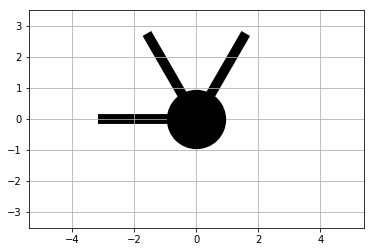

([<matplotlib.axis.XTick at 0x11bbe6e48>,
 <a list of 4 Text xticklabel objects>)

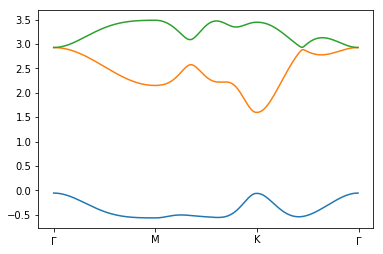

In [21]:
from math import pi, sqrt, tanh
import kwant
from matplotlib import pyplot
import numpy as np
from functools import partial
import copy
import tinyarray as ta
from kwant.wraparound import wraparound, plot_2d_bands
%matplotlib inline


# lattice constant
a = 3.19
# hopping energy
eps_1 = 1.046
eps_2 = 2.104
t0 = -0.184
t1 = 0.401
t2 = 0.507
t11 = 0.218
t12 = 0.338
t22 = 0.057
rt3 = np.sqrt(3)

h0 = ta.array([[eps_1,0,0],[0,eps_2,0],[0,0,eps_2]])

h1 = ta.array([[ t0, -t1,   t2],
      [ t1, t11, -t12],
      [ t2, t12,  t22]])

h2 = ta.array([[                    t0,     1/2 * t1 + rt3/2 * t2,     rt3/2 * t1 - 1/2 * t2],
      [-1/2 * t1 + rt3/2 * t2,     1/4 * t11 + 3/4 * t22, rt3/4 * (t11 - t22) - t12],
      [-rt3/2 * t1 - 1/2 * t2, rt3/4 * (t11 - t22) + t12,     3/4 * t11 + 1/4 * t22]])

h3 = ta.array([[                    t0,    -1/2 * t1 - rt3/2 * t2,     rt3/2 * t1 - 1/2 * t2],
      [ 1/2 * t1 - rt3/2 * t2,     1/4 * t11 + 3/4 * t22, rt3/4 * (t22 - t11) + t12],
      [-rt3/2 * t1 - 1/2 * t2, rt3/4 * (t22 - t11) - t12,     3/4 * t11 + 1/4 * t22]])

# length 
l = 10.0

# set lattice vectors and basis 
v2 = np.array((a / 2., np.sqrt(3.) * a / 2.0))
v1 = np.array((a,0))
lattice = kwant.lattice.general([v1, v2], [(0, 0)], norbs=1 )
lat = lattice.sublattices[0]

def make_system():

    def shape(pos):
        x, y = pos
        return x  > -l and x < l and y > -l and y < l

    syst = kwant.Builder(kwant.TranslationalSymmetry(*lattice.prim_vecs))
    # set the on-site energies
    syst[lattice.shape(shape, (0, 0))] = h0
    # set the hopping energies
    syst[kwant.builder.HoppingKind((1,0), lat, lat)] =  h1
    syst[kwant.builder.HoppingKind((0,-1), lat, lat)] = h2
    syst[kwant.builder.HoppingKind((1,-1), lat, lat)] = h3
    

    return syst

syst = make_system()
# syst = syst.finalized()

# # Then, plot the system with leads.
kwant.plot(syst, site_lw=0.1, lead_site_lw=0, show=False)
pyplot.axis('equal')
pyplot.grid(True)
pyplot.show()

# fig, axes = pyplot.subplots(1,1, figsize=(5,5), sharey='row')
# momenta = np.linspace(-np.pi,  np.pi, 256)
# bands0 = kwant.physics.Bands(syst.leads[0])
# energies0 = [bands0(k) for k in momenta]
# pyplot.plot(momenta, energies0, 'r')
# pyplot.ylim([-1,3])
# pyplot.show()

# Finalize the system.
syst = wraparound(syst).finalized()

gamma_to_Mx = np.linspace(0, 0, 128)
gamma_to_My = np.linspace(0, (4*np.pi / 3. / a) * np.sqrt(3) / 2.0, 128)

M_to_Kx = np.linspace(0, 4*np.pi / 3 / a, 128)
M_to_Ky = np.linspace((4*np.pi / 3. / a) * np.sqrt(3) / 2.0, 0.0, 128)

Kx_to_gamma_x = np.linspace(4*np.pi / 3 / a, 0, 128)
Ky_to_gamma_y = np.linspace(0.0, 0.0, 128)

def momentum_to_lattice(k):
    """Transform momentum to the basis of reciprocal lattice vectors.
    
    See https://en.wikipedia.org/wiki/Reciprocal_lattice#Generalization_of_a_dual_lattice
    """
    B = np.array(lattice.prim_vecs).T
    A = B.dot(np.linalg.inv(B.T.dot(B)))
    return np.linalg.solve(A, k)

energies = []
for i in range(128):
    lattice_k = momentum_to_lattice([gamma_to_Mx[i], gamma_to_My[i]])
    h = syst.hamiltonian_submatrix(args=(list(lattice_k)))
    energies.append(np.linalg.eigvalsh(h))
    
for i in range(128):
    lattice_k = momentum_to_lattice([M_to_Kx[i], M_to_Ky[i]])
    h = syst.hamiltonian_submatrix(args=(list(lattice_k)))
    energies.append(np.linalg.eigvalsh(h))
    
for i in range(128):
    lattice_k = momentum_to_lattice([Kx_to_gamma_x[i], Ky_to_gamma_y[i]])
    h = syst.hamiltonian_submatrix(args=(list(lattice_k)))
    energies.append(np.linalg.eigvalsh(h))

energies = np.array(energies)
pyplot.plot(energies[:,0])
pyplot.plot(energies[:,1])
pyplot.plot(energies[:,2])
pyplot.xticks([0,128, 256, 384], ['$\Gamma$', 'M', 'K', '$\Gamma$']*4)


[[-0.184 -0.401 0.507]
 [0.401 0.218 -0.338]
 [0.507 0.338 0.057]]

[[-0.184       0.63957488  0.09377619]
 [ 0.23857488  0.09725    -0.26828495]
 [-0.60077619  0.40771505  0.17775   ]]
[[-0.184 0.6395748797187104 0.0937761869175599]
 [0.2385748797187104 0.09725 -0.2682849549953527]
 [-0.6007761869175599 0.40771504500464734 0.17775000000000002]]

[[-0.184      -0.63957488  0.09377619]
 [-0.23857488  0.09725     0.26828495]
 [-0.60077619 -0.40771505  0.17775   ]]
[[-0.184 -0.6395748797187104 0.0937761869175599]
 [-0.2385748797187104 0.09725 0.2682849549953527]
 [-0.6007761869175599 -0.40771504500464734 0.17775000000000002]]


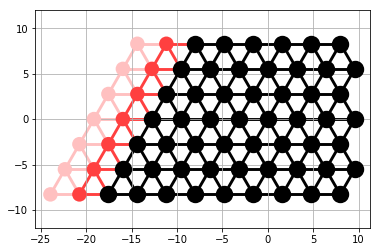

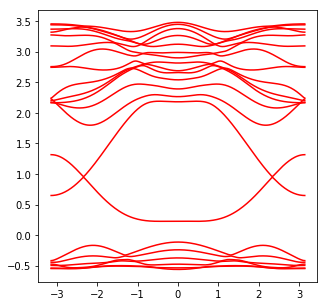

In [78]:
from math import pi, sqrt, tanh
import kwant
from matplotlib import pyplot
import numpy as np
from functools import partial
import copy
import tinyarray as ta
from kwant.wraparound import wraparound, plot_2d_bands
%matplotlib inline

# function to rotate 2D vectors
def rot(vec, theta):
    rot_mat = np.array([ [np.cos(-theta), -np.sin(-theta)], [np.sin(-theta), np.cos(-theta)] ])
    return rot_mat.dot(vec)

def simTransformX(theta, matrix):
    rotx = np.array([
                        [1, 0, 0],
                        [0, np.cos(theta), -np.sin(theta)],
                        [0, np.sin(theta), np.cos(theta)]
                    ])
    return np.matmul(np.matmul(rotx, matrix), np.matrix(rotx).H)

def simTransformY(theta, matrix):
    roty = np.array([
                        [np.cos(theta), 0, -np.sin(theta)],
                        [0,1,0],
                        [np.sin(theta),0, np.cos(theta)]
                    ])
    return np.matmul(np.matmul(roty, matrix), np.matrix(roty).H)

def simTransformZ(theta, matrix):
    rotz = np.array([
                        [np.cos(theta), -np.sin(theta), 0],
                        [np.sin(theta), np.cos(theta), 0],
                        [0, 0, 1]
                    ])
    return np.matmul(np.matmul(rotz, matrix), np.matrix(rotz).H)

def reflectZ(matrix):
    refz = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, -1]
    ])
    return np.matmul(np.matmul(refz, matrix), refz.T)

def reflectY(matrix):
    refy = np.array([
        [1, 0, 0],
        [0, -1, 0],
        [0, 0, 1]
    ])
    return np.matmul(np.matmul(refy, matrix), refy.T)

def reflectX(matrix):
    refx = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, -1]
    ])
    return np.matmul(np.matmul(refx, matrix), refx.T)
    



# lattice constant
a = 3.19
# hopping energy
eps_1 = 1.046
eps_2 = 2.104
t0 = -0.184
t1 = 0.401
t2 = 0.507
t11 = 0.218
t12 = 0.338
t22 = 0.057
rt3 = np.sqrt(3)

h0 = ta.array([[eps_1,0,0],[0,eps_2,0],[0,0,eps_2]])

h1 = ta.array([[ t0, -t1,   t2],
      [ t1, t11, -t12],
      [ t2, t12,  t22]])

h2 = ta.array([[                    t0,     1/2 * t1 + rt3/2 * t2,     rt3/2 * t1 - 1/2 * t2],
      [-1/2 * t1 + rt3/2 * t2,     1/4 * t11 + 3/4 * t22, rt3/4 * (t11 - t22) - t12],
      [-rt3/2 * t1 - 1/2 * t2, rt3/4 * (t11 - t22) + t12,     3/4 * t11 + 1/4 * t22]])

h3 = ta.array([[                    t0,    -1/2 * t1 - rt3/2 * t2,     rt3/2 * t1 - 1/2 * t2],
      [ 1/2 * t1 - rt3/2 * t2,     1/4 * t11 + 3/4 * t22, rt3/4 * (t22 - t11) + t12],
      [-rt3/2 * t1 - 1/2 * t2, rt3/4 * (t22 - t11) - t12,     3/4 * t11 + 1/4 * t22]])

print(h1)
print()
print(simTransformX(4 * np.pi / 3, h1))
print(h2)
print()
print(reflectZ(simTransformX(np.pi / 3, h1)))
print(h3)

# length 
l = 10.0

# set lattice vectors and basis 
v2 = np.array((a / 2., np.sqrt(3.) * a / 2.0))
v1 = np.array((a,0))
lattice = kwant.lattice.general([v1, v2], [(0, 0)], norbs=1 )
lat = lattice.sublattices[0]

def make_system():

    def shape(pos):
        x, y = pos
        return x  > -l and x < l and y > -l and y < l

    syst = kwant.Builder()
    # set the on-site energies
    syst[lattice.shape(shape, (0, 0))] = h0
    # set the hopping energies
    syst[kwant.builder.HoppingKind((1,0), lat, lat)] =  h1
    syst[kwant.builder.HoppingKind((0,-1), lat, lat)] = simTransformX(4 * np.pi / 3, h1)
    syst[kwant.builder.HoppingKind((1,-1), lat, lat)] = reflectZ(simTransformX(np.pi / 3, h1))
    
    lead = kwant.Builder(kwant.TranslationalSymmetry(lattice.vec((-1,0))))
    
    lead[lattice.shape(shape, (0, 0))] = h0
    # set the hopping energies
    lead[kwant.builder.HoppingKind((1,0), lat, lat)] =  h1
    lead[kwant.builder.HoppingKind((0,-1), lat, lat)] = simTransformX(4 * np.pi / 3, h1)
    lead[kwant.builder.HoppingKind((1,-1), lat, lat)] = reflectZ(simTransformX(np.pi / 3, h1))
    
    syst.attach_lead(lead)



    return syst

syst = make_system()
syst = syst.finalized()

# # Then, plot the system with leads.
kwant.plot(syst, site_lw=0.1, lead_site_lw=0, show=False)
pyplot.axis('equal')
pyplot.grid(True)
pyplot.show()

fig, axes = pyplot.subplots(1,1, figsize=(5,5), sharey='row')
momenta = np.linspace(-np.pi,  np.pi, 256)
bands0 = kwant.physics.Bands(syst.leads[0])
energies0 = [bands0(k) for k in momenta]
pyplot.plot(momenta, energies0, 'r')
# pyplot.ylim([-1,3])
pyplot.show()



